# Goal

The goal of this notebook is to help in interactively developing the new multi-objective version of the Tomograph.

## Goals for the Tomograph

1. Move away from matplotlib to either plotly, or bokeh. 
2. Make sure that:
    1. All scales are the same so that they are comparable.
    2. We should be able to plot not just predictions but also individual observations as a scatterplot. 
    3. We should be able to link the points across multiple charts to investigate them more deeply (bokeh seems to be the winner here)
    4. We should be able to connect multiple tomographs to the same optimizer, as any given analysis might focus on different aspects and each aspect should have it's own graphs.
3. The Tomograph produces a set of heatmaps that belong to 2D cross-sections of the higher-dimensional hypercube. All these cross-sections share a single point (often the optimum). The user should be able to:
    1. Select one of the predefined points (different types of optima, maybe optima for different contexts)
    2. View the resulting cross sections and sensitivity analysis for such a point
    3. Be able to use sliders to adjust the point so that they can easily "walk the hypercube"
    

Plotly has the advantage of also enabling 3D visualizations of the pareto frontier and generates surface plots etc. But bokeh has built-in support for linking data. 

Given what we need, I would start with bokeh, for dabl-style and tomograph plots, and then switch to plotly for parameter interactions, and 3D pareto visualizations.

https://docs.bokeh.org/en/latest/index.html

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from mlos.OptimizerEvaluationTools.ObjectiveFunctionFactory import ObjectiveFunctionFactory, objective_function_config_store
objective_function_config_store.list_named_configs()

[Name: default
 
 Description: None
 
 Config Values: {
   "implementation": "Hypersphere",
   "hypersphere_config.num_objectives": 3,
   "hypersphere_config.minimize": "all",
   "hypersphere_config.radius": 10,
   "description": "default"
 },
 Name: three_level_quadratic
 
 Description: None
 
 Config Values: {
   "implementation": "ThreeLevelQuadratic"
 },
 Name: flower
 
 Description: None
 
 Config Values: {
   "implementation": "Flower"
 },
 Name: noisy_polynomial_objective
 
 Description: None
 
 Config Values: {
   "implementation": "PolynomialObjective",
   "polynomial_objective_config.seed": 17,
   "polynomial_objective_config.input_domain_dimension": 2,
   "polynomial_objective_config.input_domain_min": -1024,
   "polynomial_objective_config.input_domain_width": 2048,
   "polynomial_objective_config.max_degree": 2,
   "polynomial_objective_config.include_mixed_coefficients": true,
   "polynomial_objective_config.percent_coefficients_zeroed": 0,
   "polynomial_objective_config

In [19]:
#objective_function_config = objective_function_config_store.get_config_by_name("multi_objective_2_mutually_exclusive_polynomials")
#objective_function_config = objective_function_config_store.get_config_by_name("three_level_quadratic")
objective_function_config = objective_function_config_store.get_config_by_name("2d_hypersphere_minimize_none")

objective_function = ObjectiveFunctionFactory.create_objective_function(objective_function_config)
optimization_problem = objective_function.default_optimization_problem

In [4]:
print(objective_function.default_optimization_problem)

Parameter Space:
  Name: spherical_coordinates
  Dimensions:
    radius: [0.00, 10.00]
    theta0: [0.00, 1.57]
    theta1: [0.00, 1.57]
------------------------------------------------------------
Context Space:
None
------------------------------------------------------------
Feature Space:
  Name: features
  Dimensions:
    contains_context: {False}

  IF contains_context IN {False} THEN (
    Name: spherical_coordinates
    Dimensions:
      radius: [0.00, 10.00]
      theta0: [0.00, 1.57]
      theta1: [0.00, 1.57]
  )
------------------------------------------------------------
Objective Space:
  Name: rectangular_coordinates
  Dimensions:
    y0: [0.00, 10.00]
    y1: [0.00, 10.00]
------------------------------------------------------------
Objectives:
[{'name': 'y0', 'minimize': False}, {'name': 'y1', 'minimize': False}]


In [5]:
from mlos.Optimizers.BayesianOptimizerFactory import BayesianOptimizerFactory, bayesian_optimizer_config_store
optimizer_factory = BayesianOptimizerFactory()
optimizer_config = bayesian_optimizer_config_store.default
optimizer = optimizer_factory.create_local_optimizer(
    optimizer_config=optimizer_config,
    optimization_problem=optimization_problem
)

03/09/2021 02:43:19 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 0.7,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_m

03/09/2021 02:43:19 -   BayesianOptimizerFactory -    INFO - [HomogeneousRandomForestRegressionModel.py: 120 -        _create_estimators() ] Creating DecisionTreeRegressionModel with the input_space:   Name: estimator_1_input_space
  Dimensions:
    spherical_coordinates___radius: [0.00, 10.00]
    spherical_coordinates___theta1: [0.00, 1.57]
    spherical_coordinates___theta0: [0.00, 1.57]
    contains_context: {False}
03/09/2021 02:43:19 -   BayesianOptimizerFactory -    INFO - [HomogeneousRandomForestRegressionModel.py: 120 -        _create_estimators() ] Creating DecisionTreeRegressionModel with the input_space:   Name: estimator_2_input_space
  Dimensions:
    spherical_coordinates___theta0: [0.00, 1.57]
    spherical_coordinates___theta1: [0.00, 1.57]
    contains_context: {False}
    spherical_coordinates___radius: [0.00, 10.00]
03/09/2021 02:43:19 -   BayesianOptimizerFactory -    INFO - [HomogeneousRandomForestRegressionModel.py: 120 -        _create_estimators() ] Creating De

In [6]:
params_df = objective_function.parameter_space.random_dataframe(num_samples=2000)
objectives_df = objective_function.evaluate_dataframe(params_df)

In [7]:
optimizer.register(parameter_values_pandas_frame=params_df, target_values_pandas_frame=objectives_df)

03/09/2021 02:43:19 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 153 -                  register() ] Registering 2000 parameters and 2000 objectives.


In [8]:
from mlos.Spaces import Point
from mlos.OptimizerMonitoring.Tomograph.ModelTomograph import ModelTomograph

tomograph = ModelTomograph(optimizer=optimizer)

In [9]:
config = objective_function.parameter_space.random()

In [10]:
import os
os.getpid()

460784

{
  "radius": 2.220058366706952,
  "theta0": 0.5274267504224528,
  "theta1": 1.2716869564456985
}


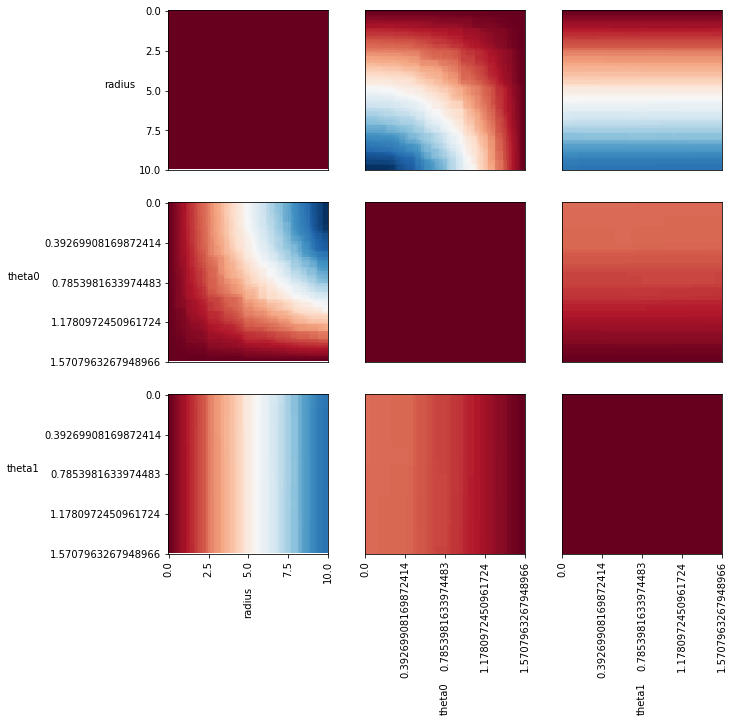

In [11]:
tomograph.plot()

## Plotting Observations
The goal of this next section is to plot all observations on a grid where:
   1. On the diagonal we plot a single parameters vs. objective value (basically what dabl does already)
   2. On the other subgraphs we plot two parameters colored according to the objective function value. Additionally, we can also regulate their opacity as a function of their distance from the plane of the graph.

In [32]:
from typing import List

from bokeh.io import output_notebook, show
from bokeh.layouts import gridplot
from bokeh.models import CategoricalTicker, ColorBar, ColumnDataSource, LinearColorMapper
from bokeh.plotting import figure

import pandas as pd

from mlos.Logger import create_logger
from mlos.Optimizers.OptimizerBase import OptimizerBase
from mlos.Spaces import CategoricalDimension, Point
from mlos.Spaces.HypergridAdapters import CategoricalToDiscreteHypergridAdapter

class Tomograph2:
    """"""    
    
    _plot_options = dict(width=500, plot_height=500, tools='wheel_zoom,box_select,lasso_select,reset')
    
    def __init__(self, optimizer: OptimizerBase, logger=None):
        if logger is None:
            logger = create_logger(self.__class__.__name__)
        self.logger = logger
        
        self.optimizer = optimizer
        self.optimization_problem = optimizer.optimization_problem
        self._feature_space_adapter = CategoricalToDiscreteHypergridAdapter(adaptee=self.optimization_problem.feature_space)
        
        self.feature_dimension_names: List[str] = [
            feature_name
            for feature_name
            in self._feature_space_adapter.dimension_names
            if feature_name != "contains_context"
        ]
        
        
        
        # Stores figure ranges by name so that we can synchronize zooming and panning
        #
        self._x_ranges_by_name = {}
        self._y_ranges_by_name = {}
        
        # Stores an array of individual plots.
        #
        self._figures = [[None for feature_name in self.feature_dimension_names] for feature_name in self.feature_dimension_names]
        
        # Stores the bokeh gridplot object.
        #
        self._grid_plot = None
        
        self._data_source = None
        self._observations_df = None
        
    
    def plot_observations(self, point: Point = None, objective_name: str = None, refresh_data: bool = True):
        """Plot all observations.
        """
        
        if objective_name is None:
            objective_name = self.optimization_problem.objectives[0].name
            
        self.logger.info(f"Plotting observations for objective {objective_name}")
            
        if self._data_source is None or self._observations_df is None or refresh_data:
            self._clear_all()
            self._refresh_data()
        
        
        color_mapper = LinearColorMapper(palette='Turbo256', low=self._observations_df[objective_name].min(), high=self._observations_df[objective_name].max())
        color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title=objective_name)
        
        for row, row_dimension_name in enumerate(self.feature_dimension_names):
            for col, col_dimension_name in enumerate(self.feature_dimension_names):
                
                                
                x_axis_name = col_dimension_name
                x_ticks, x_tick_label_mapping = self._get_feature_ticks_and_tick_label_mapping(x_axis_name)
                
                if row == col:
                    # For plots on the diagonal, we want to plot the row dimension vs. objective
                    #
                    y_axis_name = objective_name
                    y_ticks, y_tick_label_mapping = None, None
                else:
                    y_axis_name = row_dimension_name
                    y_ticks, y_tick_label_mapping = self._get_feature_ticks_and_tick_label_mapping(y_axis_name)
                
                fig = figure(**self._plot_options)
                fig.scatter(
                    x_axis_name,
                    y_axis_name,
                    color={'field': objective_name, 'transform': color_mapper},
                    source=self._data_source
                )
                fig.xaxis.axis_label = x_axis_name
                fig.yaxis.axis_label = y_axis_name
                
                
                fig.xaxis.ticker = x_ticks
                fig.axis.major_label_overrides = x_tick_label_mapping
                
                if y_ticks is not None:
                    fig.yaxis.ticker = y_ticks
                    fig.yaxis.major_label_overrides = y_tick_label_mapping
                
                self._set_ranges(fig, x_axis_name, y_axis_name)
                self._figures[row][col] = fig
                    
        
        self._figures[0][-1].add_layout(color_bar, 'right')
        self._grid_plot = gridplot(self._figures)
        
        self.logger.info(f"Data source id: {id(self._data_source)}")
        show(self._grid_plot)
        

        
    def _clear_all(self):
        self.logger.info(f"Clearing all.")
        self._x_ranges_by_name = {}
        self._y_ranges_by_name = {}
        self._figures = [[None for feature_name in self.feature_dimension_names] for feature_name in self.feature_dimension_names]
        self._grid_plot = None
        
    def _refresh_data(self):
        self.logger.info(f"Refreshing data")
        params_df, objectives_df, context_df = self.optimizer.get_all_observations()
        features_df = self.optimization_problem.construct_feature_dataframe(parameters_df=params_df, context_df=context_df, product=False)
        projected_features_df = self._feature_space_adapter.project_dataframe(features_df)
        self._observations_df = pd.concat([projected_features_df, objectives_df], axis=1)
        self._data_source = ColumnDataSource(data=self._observations_df)
        
    def _get_feature_ticks_and_tick_label_mapping(self, axis_name):
        projected_ticks = self._feature_space_adapter[axis_name].linspace(5)
        projected_ticks_df = pd.DataFrame({axis_name: projected_ticks})
        unprojected_ticks_df = self._feature_space_adapter.unproject_dataframe(projected_ticks_df)
        unprojected_col_name = unprojected_ticks_df.columns[0] 
        tick_mapping = {
            projected_tick: f"{unprojected_tick:.2f}" if isinstance(unprojected_tick, float) else str(unprojected_tick)
            for projected_tick, unprojected_tick
            in zip(projected_ticks, unprojected_ticks_df[unprojected_col_name])
        }
        return projected_ticks, tick_mapping
    
    
    def _set_ranges(self, fig, x_axis_name, y_axis_name):
        """Sets the ranges on each axis to enable synchronized panning and zooming."""
        x_range = self._x_ranges_by_name.get(x_axis_name, None)
        if x_axis_name in self._x_ranges_by_name:
            fig.x_range = self._x_ranges_by_name[x_axis_name]
        else:
            self._x_ranges_by_name[x_axis_name] = fig.x_range
        
        if y_axis_name in self._y_ranges_by_name:
            fig.y_range = self._y_ranges_by_name[y_axis_name]
        else:
            self._y_ranges_by_name[y_axis_name] = fig.y_range
        
output_notebook()       
tomograph2 = Tomograph2(optimizer=optimizer)
for objective in optimization_problem.objectives:
    tomograph2.plot_observations(objective_name=objective.name, refresh_data=False)

Loading BokehJS ...

03/09/2021 03:11:28 -                 Tomograph2 -    INFO - [<ipython-input-32-fe160654ebcc>:  62 -         plot_observations() ] Plotting observations for objective y0
03/09/2021 03:11:28 -                 Tomograph2 -    INFO - [<ipython-input-32-fe160654ebcc>: 119 -                _clear_all() ] Clearing all.
03/09/2021 03:11:28 -                 Tomograph2 -    INFO - [<ipython-input-32-fe160654ebcc>: 126 -             _refresh_data() ] Refreshing data
03/09/2021 03:11:29 -                 Tomograph2 -    INFO - [<ipython-input-32-fe160654ebcc>: 113 -         plot_observations() ] Data source id: 86852416


03/09/2021 03:11:29 -                 Tomograph2 -    INFO - [<ipython-input-32-fe160654ebcc>:  62 -         plot_observations() ] Plotting observations for objective y1
03/09/2021 03:11:29 -                 Tomograph2 -    INFO - [<ipython-input-32-fe160654ebcc>: 113 -         plot_observations() ] Data source id: 86852416
